In [1]:
%env CUDA_VISIBLE_DEVICES=1 # set device number

import os
import json
from PIL import Image
import torch
from transformers import BlipForConditionalGeneration, BlipProcessor
from diffusers import DDIMScheduler, DDIMInverseScheduler
from pix2pix_zero.pipeline_stable_diffusion_pix2pix_zero_nmg import StableDiffusionPix2PixZeroPipeline

env: CUDA_VISIBLE_DEVICES=1 # set device number


In [2]:
# load caption generator
captioner_id = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(captioner_id)
model = BlipForConditionalGeneration.from_pretrained(
    captioner_id, torch_dtype=torch.float16, low_cpu_mem_usage=True
)

# load stable diffusion
sd_model_ckpt = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPix2PixZeroPipeline.from_pretrained(
    sd_model_ckpt,
    caption_generator=model,
    caption_processor=processor,
    torch_dtype=torch.float16
)

# set scheduler and invere scheduler
pipeline.scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipeline.inverse_scheduler = DDIMInverseScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_zero=False)
pipeline.enable_model_cpu_offload()

# set prompts
with open(os.path.join('pix2pix_zero/cat_prompts.json'), 'r') as cat_file,\
     open(os.path.join('pix2pix_zero/dog_prompts.json'), 'r') as dog_file:
    cat_prompts = json.load(cat_file)
    dog_prompts = json.load(dog_file)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## Cat &rarr; Dog

In [3]:
# compute embeddings
source_embeds = pipeline.get_embeds(cat_prompts)
target_embeds = pipeline.get_embeds(dog_prompts)

# load image
img_path = 'images/img8.jpg'
raw_image = Image.open(img_path).convert("RGB").resize((512, 512))

# generate caption
caption = pipeline.generate_caption(raw_image)

# inversion
inv_latents_list = pipeline.invert(caption, image=raw_image).latents
inv_latents = inv_latents_list[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

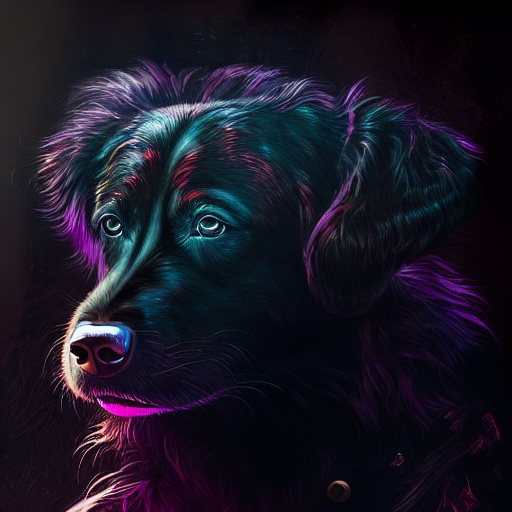

In [4]:
# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale

# pix2pixzero with noise map condition
generator = torch.Generator(device="cuda").manual_seed(0)
image = pipeline.p2p_nmg(
    caption,
    source_embeds=source_embeds,
    target_embeds=target_embeds,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
    generator=generator,
    latents=inv_latents,
    negative_prompt=caption,
    guidance_scale=guidance_text,
    grad_scale=grad_scale,
    guidance_noise_map=guidance_noise_map,
    forward_latents=inv_latents_list
).images[1][0]
image

## Dog &rarr; Cat

In [8]:
# compute embeddings
source_embeds = pipeline.get_embeds(dog_prompts)
target_embeds = pipeline.get_embeds(cat_prompts)

# load image
img_path = 'images/img9.jpg'
raw_image = Image.open(img_path).convert("RGB").resize((512, 512))

# generate caption
caption = pipeline.generate_caption(raw_image)

# inversion
inv_latents_list = pipeline.invert(caption, image=raw_image).latents
inv_latents = inv_latents_list[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

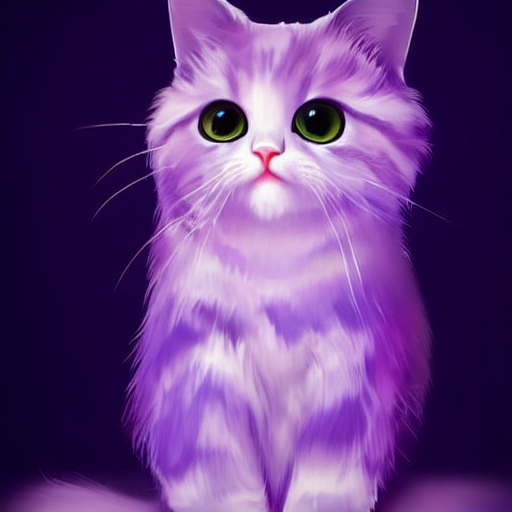

In [9]:
# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale

# pix2pixzero with noise map condition
generator = torch.Generator(device="cuda").manual_seed(0)
image = pipeline.p2p_nmg(
    caption,
    source_embeds=source_embeds,
    target_embeds=target_embeds,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
    generator=generator,
    latents=inv_latents,
    negative_prompt=caption,
    guidance_scale=guidance_text,
    grad_scale=grad_scale,
    guidance_noise_map=guidance_noise_map,
    forward_latents=inv_latents_list
).images[1][0]
image